In [1]:
from psamm.datasource import native
from psamm.fluxanalysis import FluxBalanceProblem, FluxBalanceError
from psamm.lpsolver import cplex, lp
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
def lin_model(NGAM, fit_intercept=True):
    """
    Given an NGAM curve, build and return a linear model object
    Format the input vector like so:
    [(x1,y1) (x2,y2) (x3,y3) (x4,y4)...]
    """
    x = np.array([a[0] for a in NGAM]).reshape((-1, 1))
    y = np.array([a[1] for a in NGAM])
    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(x,y)
    m = model.coef_[0]
    b = model.intercept_
    r2 = model.score(x,y)
    #print("y = {m}x + {b}".format(m=model.coef_[0], b=model.intercept_))
    #print("R2 = {s}".format(s=model.score(x,y)))
    return model, r2

### Preparation
The code below assumes:
1. The code is being run from the GEM-iCbes/manuscript directory
2. EX_Kengen_94.tsv is loaded in model.yaml

`git checkout` is used to reset files to the git HEAD so that no temporary configurations are used for the GAM calibration. This should also confirm that EX_Kengen_94.tsv is correctly loaded in the model.yaml unless this is changed in a future commit. **Verify that there are no uncommitted changes in your directory that you don't want to lose**

In [3]:
os.chdir("..")
subprocess.run(["git", "checkout", "--", "."], capture_output=True)

CompletedProcess(args=['git', 'checkout', '--', '.'], returncode=0, stdout=b'', stderr=b'')

In [4]:
%%capture
validation_data = pd.read_csv("./manuscript/data/validation_data2.csv")
# make sure EX_Kengen is loaded, doesn't need carbon added
model_reader = native.ModelReader.reader_from_path(".")
native_model = model_reader.create_model()
#metabolic_model = native_model.create_metabolic_model()
solver = cplex.Solver()

carbon_assoc = {"Maltose": "EX_C00208[e]", "Cellobiose": "EX_C00185[e]", "Pyruvate": "EX_C00022[e]"}

output = pd.DataFrame(columns=["Substrate", "substrate_conc", "growth_yield", "NGAM"])
for id,row in validation_data.iterrows():
    # have to reread the metabolic model to reset the bounds each time
    # otherwise it will throw an error when you set a lower bound
    # higher than the previous upper bound
    metabolic_model = native_model.create_metabolic_model()
    for substrate, exch in carbon_assoc.items():
        if row["Substrate"] != substrate: # set other carbon sources to 0
            metabolic_model.limits[exch].lower = 0
            metabolic_model.limits[exch].upper = 1000
        else: # set the target substrate
            metabolic_model.limits[exch].lower = row["carbon_lb"]
            metabolic_model.limits[exch].upper = row["carbon_ub"]
    # set product requirements
    metabolic_model.limits["EX_C00033[e]"].lower = row["acetate_lb"] # acetate
    metabolic_model.limits["EX_C00033[e]"].upper = row["acetate_ub"] # acetate
    metabolic_model.limits["EX_C00011[e]"].lower = row["co2_lb"] # CO2
    metabolic_model.limits["EX_C00011[e]"].upper = row["co2_ub"] # CO2
    metabolic_model.limits["EX_C00041[e]"].lower = row["alanine_lb"] # Alanine
    metabolic_model.limits["EX_C00041[e]"].upper = row["alanine_ub"] # Alanine
    metabolic_model.limits["EX_C00282[e]"].lower = row["h2_lb"] # Hydrogen
    metabolic_model.limits["EX_C00282[e]"].upper = row["h2_ub"] # Hydrogen
    metabolic_model.limits["EX_C00469[e]"].lower = row["ethanol_lb"] # Ethanol
    metabolic_model.limits["EX_C00469[e]"].upper = row["ethanol_ub"] # Ethanol
    metabolic_model.limits["Biomass_Pfu"].upper = row["growth_yield"] # Growth
    metabolic_model.limits["Biomass_Pfu"].lower = row["growth_yield"] # Growth
    metabolic_model.add_reaction("NGAM")
    metabolic_model.add_reaction("sink_biomass")
    metabolic_model.remove_reaction("GAM_biomass")
    #metabolic_model.has_reaction("NGAM")
    metabolic_model.limits["NGAM"].lower=0
    metabolic_model.limits["NGAM"].upper=1000
    fbp = FluxBalanceProblem(metabolic_model, solver)
    #growth = fbp.flux_bound("Biomass_Pfu", 1)
    fbp.max_min_l1("NGAM")
    growth = fbp.get_flux("Biomass_Pfu")
    NGAM = fbp.get_flux("NGAM")
    # NGAM calibration
    output = output.append({"Substrate": row["Substrate"],
                            "substrate_conc": row["substrate_conc"],
                            "growth_yield": growth,
                            "NGAM": NGAM},
                           ignore_index=True)

figS1_dat = validation_data[["Substrate",
                            "substrate_conc",
                            "growth_yield"]].join(output.set_index(["Substrate",
                                                                    "substrate_conc"]),
                                                  on=["Substrate", "substrate_conc"],
                                                  lsuffix="_exp", rsuffix="_simu")

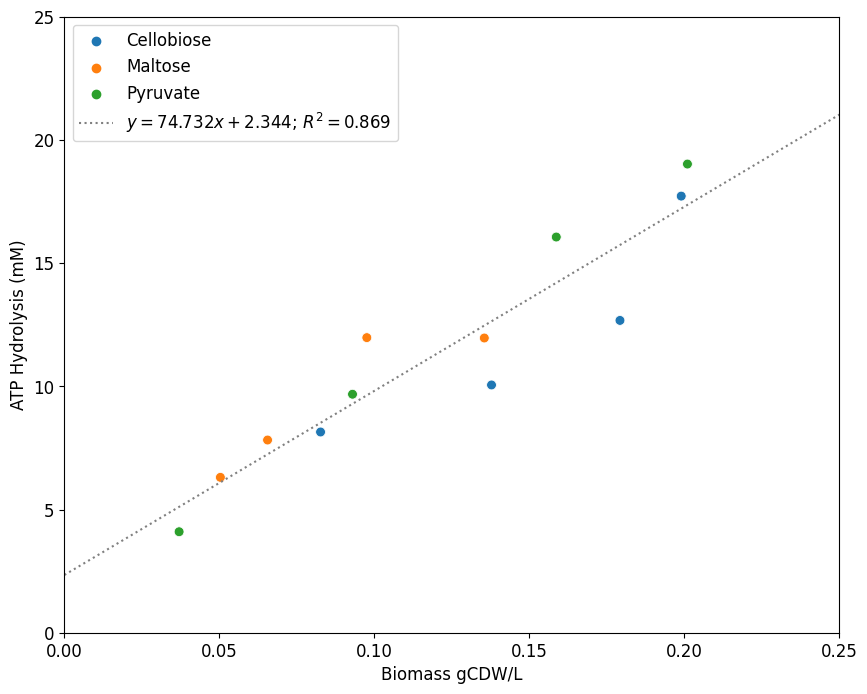

In [5]:
with plt.rc_context({"figure.figsize": (10,8), "font.size": 12}):
    sns.scatterplot(data=figS1_dat, x="growth_yield_exp", y="NGAM", hue="Substrate", s=50)
    lm, r2 = lin_model(list(zip(figS1_dat["growth_yield_exp"], figS1_dat["NGAM"])), fit_intercept=True)
    plt.axline((0, lm.predict([[0]])[0]), (1, lm.predict([[1]])[0]), ls="dotted", color="grey",
               label="$y = {m}x + {b}$; $R^2 = {r}$".format(
                   m=round(lm.coef_[0], 3), b=round(lm.intercept_, 3), r=round(r2, 3)
               ))
    plt.xlabel("Biomass gCDW/L")
    plt.ylabel("ATP Hydrolysis (mM)")
    plt.xlim([0,0.25])
    plt.ylim([0,25])
    plt.legend()
    #plt.savefig("/home/jason_vailionis_uri_edu/git/GEM_iPfu/scripts/manuscript/figures/FigS1.png")
    plt.savefig("./manuscript/figures/FigS1.tiff",
               dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    plt.show()

In [6]:
GAM = lm.coef_[0]
NGAM = lm.intercept_
print("GAM: ", GAM)
print("NGAM: ", NGAM)

GAM:  74.73168777005988
NGAM:  2.3437164062871094


In [7]:
print(1/GAM)

0.013381204544407933


### Edit the model files to apply GAM and NGAM for all future simulations
The equation 'GAM_biomass' is defined in `biomass.yaml`. It is a combination of a biomass sink and the ATP hydrolysis reaction. The coefficient on the Biomass compound in this reaction should be set to 1/GAM (derived above). The formatted GAM_biomass equation is:
```
- id: GAM_biomass
  equation: (0.01338) Biomass[c] + C00002[c] + C00001[c] => C00008[c] + C00009[c]
```

The equation 'NGAM' is defined in `spontaneous.yaml`. It is the ATP hydrolysis reaction. This reaction must be fixed to the NGAM value derived above, which can be done by adding the following to `limits.yaml`:

```
- reaction: NGAM
  fixed: 2.344
```

In [13]:
%%capture
model_reader = native.ModelReader.reader_from_path(".")
native_model = model_reader.create_model()
#metabolic_model = native_model.create_metabolic_model()
solver = cplex.Solver()

carbon_assoc = {"Maltose": "EX_C00208[e]", "Cellobiose": "EX_C00185[e]", "Pyruvate": "EX_C00022[e]"}

output = pd.DataFrame(columns=["Substrate", "substrate_conc", "growth_yield"])
for id,row in validation_data.iterrows():
    metabolic_model = native_model.create_metabolic_model()
    for substrate, exch in carbon_assoc.items():
        if row["Substrate"] != substrate: # Set other carbon sources to 0
            metabolic_model.limits[exch].lower = 0
            metabolic_model.limits[exch].upper = 1000
        else: # Set substrate constraints
            metabolic_model.limits[exch].lower = row["carbon_lb"]
            metabolic_model.limits[exch].upper = row["carbon_ub"]
    # Set product constraints
    metabolic_model.limits["EX_C00033[e]"].lower = row["acetate_lb"] # acetate
    metabolic_model.limits["EX_C00033[e]"].upper = row["acetate_ub"] # acetate
    metabolic_model.limits["EX_C00011[e]"].lower = row["co2_lb"] # CO2
    metabolic_model.limits["EX_C00011[e]"].upper = row["co2_ub"] # CO2
    metabolic_model.limits["EX_C00041[e]"].lower = row["alanine_lb"] # Alanine
    metabolic_model.limits["EX_C00041[e]"].upper = row["alanine_ub"] # Alanine
    metabolic_model.limits["EX_C00282[e]"].lower = row["h2_lb"] # Hydrogen
    metabolic_model.limits["EX_C00282[e]"].upper = row["h2_ub"] # Hydrogen
    metabolic_model.limits["EX_C00469[e]"].lower = row["ethanol_lb"] # Ethanol
    metabolic_model.limits["EX_C00469[e]"].upper = row["ethanol_ub"] # Ethanol
    fbp = FluxBalanceProblem(metabolic_model, solver)
    fbp.maximize("GAM_biomass")
    growth = fbp.get_flux("Biomass_Pfu")
    output = output.append({"Substrate": row["Substrate"],
                            "substrate_conc": row["substrate_conc"],
                            "growth_yield": growth},
                           ignore_index=True)

fig2_dat = validation_data[["Substrate",
                            "substrate_conc",
                            "growth_yield"]].join(output.set_index(["Substrate",
                                                                    "substrate_conc"]),
                                                  on=["Substrate", "substrate_conc"],
                                                  lsuffix="_exp", rsuffix="_simu")

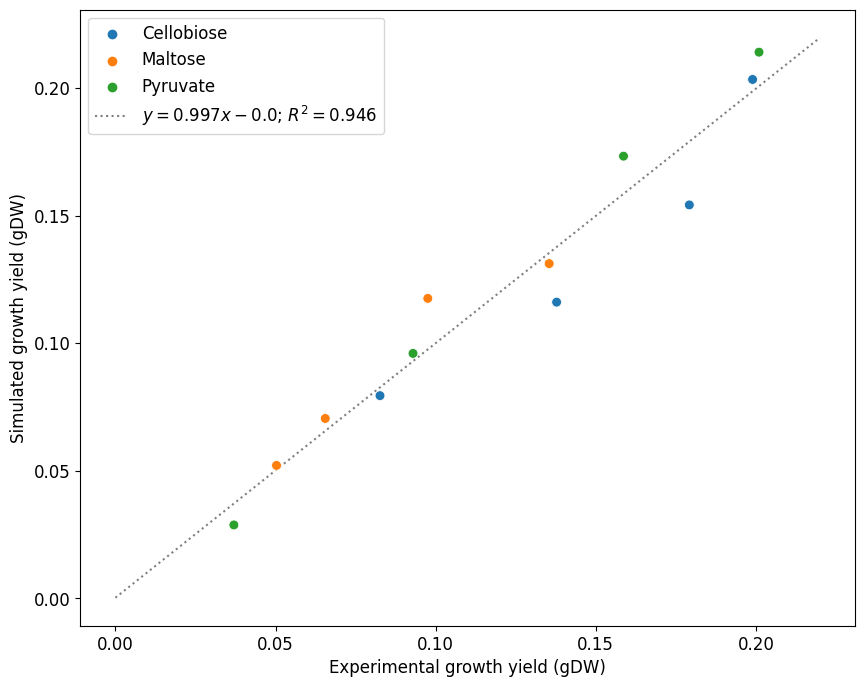

In [14]:
with plt.rc_context({"figure.figsize": (10,8), "font.size": 12}):
    sns.scatterplot(data=fig2_dat, x="growth_yield_exp", y="growth_yield_simu",
                    hue="Substrate", s=50)
    m, r2 = lin_model(list(zip(fig2_dat["growth_yield_exp"], fig2_dat["growth_yield_simu"])))
    plt.plot(sorted(list(fig2_dat["growth_yield_exp"])+[0,0.22]),
             m.predict(np.array(sorted(list(fig2_dat["growth_yield_exp"])+[0,0.22])).reshape(-1,1)),
             ls="dotted", color="grey", zorder=0,
             label="$y = {m}x - {b}$; $R^2 = {r}$".format(
                m=round(m.coef_[0], 3), b=round(m.intercept_, 3), r=round(r2, 3)
             ))
    plt.legend(loc="upper left")
    plt.ylabel("Simulated growth yield (gDW)")
    plt.xlabel("Experimental growth yield (gDW)")
    plt.savefig("./manuscript/figures/Fig2.tiff",
               dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    plt.show()

#### Data S3 
The table below is copied into Data Set S3

In [10]:
fig2_dat

,Substrate,substrate_conc,growth_yield_exp,growth_yield_simu
0,Cellobiose,3.45,0.082630,0.079446
1,Cellobiose,5.33,0.137780,0.116077
2,Cellobiose,7.36,0.179215,0.154157
3,Cellobiose,10.50,0.198975,0.203305
4,Maltose,1.86,0.050315,0.052116
5,Maltose,2.57,0.065535,0.070513
6,Maltose,4.58,0.097555,0.117548
7,Maltose,5.17,0.135455,0.131174
8,Pyruvate,5.58,0.037000,0.028804
9,Pyruvate,14.80,0.092940,0.095993
